In [7]:
import sys
sys.path.append('../')
%matplotlib inline
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np


# Изменим стандартный размер графиков matplotlib
plt.rcParams["figure.figsize"] = [6, 4]

In [8]:

import numpy as np
import matplotlib as plt
import cv2 as cv


def show_image(image):
    cv.imshow("Image", image)
    cv.waitKey(0)
    cv.destroyAllWindows()


def display_image(filename):
    image = cv.imread(filename)
    assert (image is not None), "Image is None! Check image path"
    show_image(image)
    return image


def add_gauss_noise(image, mean, sigma):
    image = np.array(image / 255, dtype=float)
    noise = np.random.normal(mean, sigma, image.shape)
    noisy_image = image + noise
    out = np.clip(noisy_image, 0, 1.0)
    out = np.uint8(out * 255)
    return out


def add_salt_and_peper_noise(im, fraction=0.01):
    assert (0 < fraction <= 1.), "Fraction must be in (0, 1]"

    sp = np.zeros(im.shape)
    percent = round(fraction * 100 / 2.)

    cv.randu(sp, 0, 100)

    # quarter salt quarter pepper
    im_sp = im.copy()
    im_sp[sp < percent] = 0
    im_sp[sp > 100 - percent] = 255
    return im_sp


def getPSNR(I1, I2):
    s1 = cv.absdiff(I1, I2)  #|I1 - I2|
    s1 = np.float64(s1)  # cannot make a square on 8 bits
    s1 = s1 * s1  # |I1 - I2|^2
    sse = s1.sum()  # sum elements per channel
    if sse <= 1e-10:  # sum channels
        return 0  # for small values return zero
    else:
        mse = 1.0 * sse / np.prod(I1.shape)
        psnr = 10.0 * np.log10((255 * 255) / mse)
        return psnr


def getSSIM(i1, i2):
    C1 = 6.5025  # only for 8-bit images
    C2 = 58.5225  # only for 8-bit images
    # INITS
    I1 = np.float64(i1)  # cannot calculate on one byte large values
    I2 = np.float64(i2)
    I2_2 = I2 * I2  # I2^2
    I1_2 = I1 * I1  # I1^2
    I1_I2 = I1 * I2  # I1 * I2
    # END INITS
    # PRELIMINARY COMPUTING
    mu1 = cv.GaussianBlur(I1, (11, 11), 1.5)
    mu2 = cv.GaussianBlur(I2, (11, 11), 1.5)
    mu1_2 = mu1 * mu1
    mu2_2 = mu2 * mu2
    mu1_mu2 = mu1 * mu2
    sigma1_2 = cv.GaussianBlur(I1_2, (11, 11), 1.5)
    sigma1_2 -= mu1_2
    sigma2_2 = cv.GaussianBlur(I2_2, (11, 11), 1.5)
    sigma2_2 -= mu2_2
    sigma12 = cv.GaussianBlur(I1_I2, (11, 11), 1.5)
    sigma12 -= mu1_mu2
    t1 = 2 * mu1_mu2 + C1
    t2 = 2 * sigma12 + C2
    t3 = t1 * t2  # t3 = ((2*mu1_mu2 + C1).*(2*sigma12 + C2))
    t1 = mu1_2 + mu2_2 + C1
    t2 = sigma1_2 + sigma2_2 + C2
    t1 = t1 * t2  # t1 =((mu1_2 + mu2_2 + C1).*(sigma1_2 + sigma2_2 + C2))
    ssim_map = cv.divide(t3, t1)  # ssim_map =  t3./t1;
    ssim = np.mean(ssim_map)  # mssim = average of ssim map
    return ssim

In [9]:
def getPSNR(I1, I2):
    s1 = cv.absdiff(I1, I2)  #|I1 - I2|
    s1 = np.float32(s1)  # cannot make a square on 8 bits
    s1 = s1 * s1  # |I1 - I2|^2
    sse = s1.sum()  # sum elements per channel
    if sse <= 1e-10:  # sum channels
        return 0  # for small values return zero
    else:
        shape = I1.shape
        mse = 1.0 * sse / (shape[0] * shape[1] * shape[2])
        psnr = 10.0 * np.log10((255 * 255) / mse)
        return psnr

In [10]:
def getSSIM(i1, i2):
    C1 = 6.5025  # only for 8-bit images
    C2 = 58.5225  # only for 8-bit images
    # INITS
    I1 = np.float32(i1)  # cannot calculate on one byte large values
    I2 = np.float32(i2)
    I2_2 = I2 * I2  # I2^2
    I1_2 = I1 * I1  # I1^2
    I1_I2 = I1 * I2  # I1 * I2
    # END INITS
    # PRELIMINARY COMPUTING
    mu1 = cv.GaussianBlur(I1, (11, 11), 1.5)
    mu2 = cv.GaussianBlur(I2, (11, 11), 1.5)
    mu1_2 = mu1 * mu1
    mu2_2 = mu2 * mu2
    mu1_mu2 = mu1 * mu2
    sigma1_2 = cv.GaussianBlur(I1_2, (11, 11), 1.5)
    sigma1_2 -= mu1_2
    sigma2_2 = cv.GaussianBlur(I2_2, (11, 11), 1.5)
    sigma2_2 -= mu2_2
    sigma12 = cv.GaussianBlur(I1_I2, (11, 11), 1.5)
    sigma12 -= mu1_mu2
    t1 = 2 * mu1_mu2 + C1
    t2 = 2 * sigma12 + C2
    t3 = t1 * t2  # t3 = ((2*mu1_mu2 + C1).*(2*sigma12 + C2))
    t1 = mu1_2 + mu2_2 + C1
    t2 = sigma1_2 + sigma2_2 + C2
    t1 = t1 * t2  # t1 =((mu1_2 + mu2_2 + C1).*(sigma1_2 + sigma2_2 + C2))
    ssim_map = cv.divide(t3, t1)  # ssim_map =  t3./t1;
    ssim = cv.mean(ssim_map)  # mssim = average of ssim map
    ssim = ssim[:3]
    return ssim

In [11]:
image1 = cv.imread('test_fixed.png')
image2 = cv.imread('test_fixed.png')
gray_image1 = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)
gray_image2 = cv.cvtColor(image2, cv.COLOR_BGR2GRAY)
rgb_image1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)
rgb_image2 = cv.cvtColor(image2, cv.COLOR_BGR2RGB)

# rgb_image1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)

gs = plt.GridSpec(1, 2)
plt.figure(figsize=(10, 4))
plt.subplot(gs[0])
plt.imshow(rgb_image1)
plt.title('test_fixed.png')
plt.xticks([]), plt.yticks([])
plt.subplot(gs[1])
plt.imshow(rgb_image2)
plt.title('test_fixed_bad.png')
plt.xticks([]), plt.yticks([])

print('PSNR = ', getPSNR(image1, image2))
print('SSIM = ', getSSIM(image1, image2))

AttributeError: module 'matplotlib' has no attribute 'GridSpec'

In [12]:
gs = plt.GridSpec(1, 3)
plt.figure(figsize=(17, 4))

plt.subplot(gs[0])
plt.title('Исходное изображение')
plt.xticks([]), plt.yticks([])
plt.imshow(gray_image1, cmap='gray')

plt.subplot(gs[1])
plt.xticks([]), plt.yticks([])
noisy_image = add_salt_and_peper_noise(gray_image1, 0.2)
psnr = getPSNR(gray_image1, noisy_image)
ssim = getSSIM(gray_image1, noisy_image)
plt.title(f'Изображение зашумленное шумом соль и перец \n PSNR = {psnr:.3f} \n SSIM = {ssim:.3f}')
plt.imshow(noisy_image, cmap='gray')

plt.subplot(gs[2])
plt.xticks([]), plt.yticks([])
noisy_image = add_gauss_noise(gray_image1, 0, 0.2)
psnr = getPSNR(gray_image1, noisy_image)
ssim = getSSIM(gray_image1, noisy_image)
plt.title(f'Изображение зашумленное гаусовским шумом \n PSNR = {psnr:.3f} \n SSIM = {ssim:.3f}')
plt.imshow(noisy_image, 'gray')
plt.show()

AttributeError: module 'matplotlib' has no attribute 'GridSpec'

In [13]:
image1 = cv.imread('test_fixed.png')
gray_image1 = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)

sap_image1 = add_salt_and_peper_noise(gray_image1, 0.2)
median_image1 = cv.medianBlur(sap_image1, 3)
median_image2 = cv.medianBlur(sap_image1, 5)

gs = plt.GridSpec(2, 2)
plt.figure(figsize=(8, 10))
plt.subplot(gs[0])
plt.imshow(gray_image1, cmap='gray')
plt.title('Исходное изображение')

plt.subplot(gs[1])
plt.imshow(sap_image1, cmap='gray')
psnr = getPSNR(gray_image1, sap_image1)
ssim = getSSIM(gray_image1, sap_image1)
plt.title(f'Изображение зашумленное \n шумом соль и перец \n PSNR = {psnr:.3f} \n SSIM = {ssim:.3f}')

plt.subplot(gs[2])
plt.imshow(median_image1, cmap='gray')
psnr = getPSNR(gray_image1, median_image1)
ssim = getSSIM(gray_image1, median_image1)
plt.title(f'Восстановленное изображение \n '
          f'медианным фильтром 3х3 \n'
          f'PSNR = {psnr:.3f} \n SSIM = {ssim:.3f}')

plt.subplot(gs[3])
plt.imshow(median_image2, cmap='gray')
psnr = getPSNR(gray_image1, median_image2)
ssim = getSSIM(gray_image1, median_image2)
plt.title(f'Восстановленное изображение \n '
          f'медианным фильтром 5х5 \n'
          f'PSNR = {psnr:.3f} \n SSIM = {ssim:.3f}')

plt.show()

AttributeError: module 'matplotlib' has no attribute 'GridSpec'

In [14]:
kernel55 = np.ones((5, 5), np.float32) / 25
kernel77 = np.ones((7, 7), np.float32) / 49

noisy_image = add_gauss_noise(gray_image1, 0, 0.15)

filtered_image1 = cv.filter2D(noisy_image, -1, kernel55)
filtered_image2 = cv.filter2D(noisy_image, -1, kernel77)
gaussian_image1 = cv.GaussianBlur(noisy_image, (7, 7), 0)
gaussian_image2 = cv.GaussianBlur(noisy_image, (15, 15), 0)

# вывод
gs = plt.GridSpec(2, 3)
plt.figure(figsize=(15, 12))

plt.subplot(gs[0, 0])
plt.xticks([]), plt.yticks([])
plt.title('Исходное изображение')
plt.imshow(gray_image1, cmap='gray')

plt.subplot(gs[1, 0])
plt.xticks([]), plt.yticks([])
plt.imshow(noisy_image, cmap='gray')
psnr = getPSNR(gray_image1, noisy_image)
ssim = getSSIM(gray_image1, noisy_image)
plt.title(f'Изображение зашумленное гауссовским шумом \n PSNR = {psnr:.3f} \n SSIM = {ssim:.3f}')

plt.subplot(gs[0, 1])
plt.xticks([]), plt.yticks([])
plt.title(f'Результат средней линейной \n фильрации с ядром 5х5 \n '
          f'PSNR = {getPSNR(gray_image1, filtered_image1):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, filtered_image1):.3f}')
plt.imshow(filtered_image1, 'gray')

plt.subplot(gs[0, 2])
plt.xticks([]), plt.yticks([])
plt.title(f'Результат средней линейной \n фильрации с ядром 7х7 \n '
          f'PSNR = {getPSNR(gray_image1, filtered_image2):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, filtered_image2):.3f}')
plt.imshow(filtered_image2, 'gray')

plt.subplot(gs[1, 1])
plt.xticks([]), plt.yticks([])
plt.title(f'Результат гауссовской  \n фильрации с ядром 7х7 \n '
          f'PSNR = {getPSNR(gray_image1, gaussian_image1):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, gaussian_image1):.3f}')
plt.imshow(gaussian_image1, 'gray')

plt.subplot(gs[1, 2])
plt.xticks([]), plt.yticks([])
plt.title(f'Результат гауссовской  \n фильрации с ядром 15х15 \n '
          f'PSNR = {getPSNR(gray_image1, gaussian_image2):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, gaussian_image2):.3f}')
plt.imshow(gaussian_image2, 'gray')

plt.show()

AttributeError: module 'matplotlib' has no attribute 'GridSpec'

In [15]:
kernel1 = np.asarray([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
kernel2 = np.asarray([[-0.25, -0.25, -0.25], [-0.25, 3, -0.25], [-0.25, -0.25, -0.25]])
kernel3 = np.asarray([[0, -0.25, 0], [-0.25, 2, -0.25], [0, -0.25, 0]])

gray_image1_median = cv.medianBlur(gray_image1, 3)

filtered_image1 = cv.filter2D(gray_image1, -1, kernel1)
filtered_image1_median = cv.filter2D(gray_image1_median, -1, kernel1)
filtered_image2 = cv.filter2D(gray_image1, -1, kernel2)
filtered_image2_median = cv.filter2D(gray_image1_median, -1, kernel2)
filtered_image3 = cv.filter2D(gray_image1, -1, kernel3)
filtered_image3_median = cv.filter2D(gray_image1_median, -1, kernel3)

# вывод
plt.figure(figsize=(15, 17))

plt.subplot(331)
plt.xticks([]), plt.yticks([])
plt.title('Исходное изображение')
plt.imshow(gray_image1, cmap='gray')

plt.subplot(334)
plt.xticks([]), plt.yticks([])
plt.title(f'Исходное изображение отфильтрованное \n медианным фильтром \n'
          f'PSNR = {getPSNR(gray_image1, gray_image1_median):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, gray_image1_median):.3f}')
plt.imshow(gray_image1_median, cmap='gray')

plt.subplot(332)
plt.xticks([]), plt.yticks([])
plt.title(f'Свертка изображения с ядром 1 \n'
          f'PSNR = {getPSNR(gray_image1, filtered_image1):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, filtered_image1):.3f}')
plt.imshow(filtered_image1, 'gray')

plt.subplot(333)
plt.xticks([]), plt.yticks([])
plt.title(f'Свертка отфильтрованного изображения с ядром 1 \n'
          f'PSNR = {getPSNR(gray_image1, filtered_image1_median):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, filtered_image1_median):.3f}')
plt.imshow(filtered_image1_median, 'gray')

plt.subplot(335)
plt.xticks([]), plt.yticks([])
plt.title(f'Свертка изображения с ядром 2 \n'
          f'PSNR = {getPSNR(gray_image1, filtered_image2):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, filtered_image2):.3f}')
plt.imshow(filtered_image2, 'gray')

plt.subplot(336)
plt.xticks([]), plt.yticks([])
plt.title(f'Свертка изображения с ядром 3 \n'
          f'PSNR = {getPSNR(gray_image1, filtered_image3):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, filtered_image3):.3f}')
plt.imshow(filtered_image3, 'gray')

plt.show()

TypeError: 'module' object is not callable

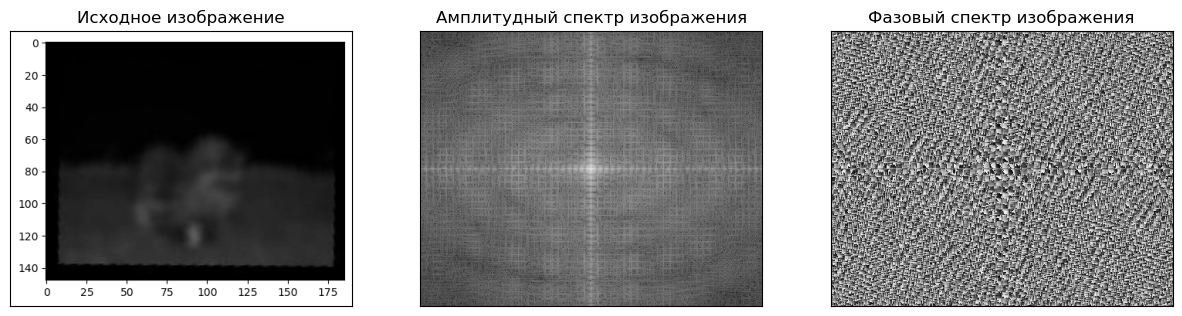

In [19]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img = cv.imread('test_fixed.png')
gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
f = np.fft.fft2(gray_img)
fshift = np.complex64(np.fft.fftshift(f))
magnitude_spectrum = 20 * np.log(np.abs(fshift))
phase_spectrum = np.uint8(255 * (np.angle(fshift) + np.pi) / (2 * np.pi))

# вывод
plt.figure(figsize=(15, 12))
plt.subplot(131), plt.imshow(gray_img, cmap='gray')
plt.title('Исходное изображение'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Амплитудный спектр изображения'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(phase_spectrum, cmap='gray')
plt.title('Фазовый спектр изображения'), plt.xticks([]), plt.yticks([])
plt.show()

C:\Users\student\AppData\Local\Temp\ipykernel_8624\707492974.py:20: RuntimeWarning: divide by zero encountered in log
  magnitude_dft_shift_masked = 20 * np.log(


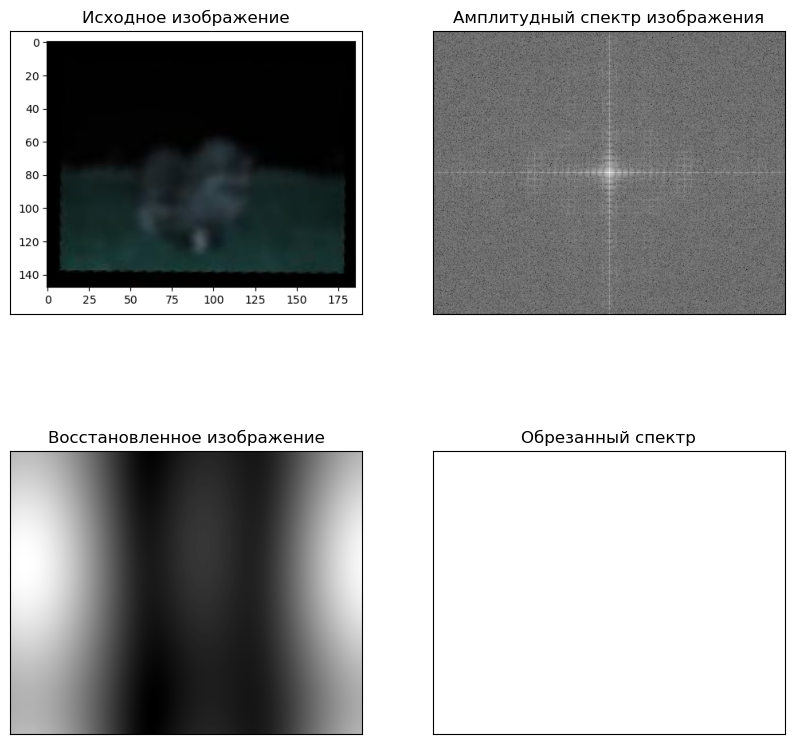

In [17]:
r = 1
rows, cols = noisy_image.shape
crow, ccol = np.uint32((rows / 2, cols / 2.220))
# create a mask first, center square is 1, remaining all zeros
mask = np.zeros((rows, cols, 2), np.uint8)
mask[crow - r:crow + r, ccol - r:ccol + r*2] = 1

# вычисляем фурье-образ
dft = cv.dft(np.float32(noisy_image), flags=cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

# применяем маску и делаем обратное преобразование Фурье
dft_shift_masked = dft_shift * mask
f_ishift = np.fft.ifftshift(dft_shift_masked)
img_back = cv.idft(f_ishift)
img_back = cv.magnitude(img_back[..., 0], img_back[..., 1])

magnitude_dft_shift = 20 * np.log(
    cv.magnitude(dft_shift[..., 0], dft_shift[..., 1]))
magnitude_dft_shift_masked = 20 * np.log(
    cv.magnitude(dft_shift_masked[..., 0], dft_shift_masked[..., 1]))

# вывод
plt.figure(figsize=(10, 10))
plt.subplot(221), plt.imshow(img, cmap='gray')
plt.title('Исходное изображение'), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(magnitude_dft_shift, cmap='gray')
plt.title('Амплитудный спектр изображения'), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(img_back, cmap='gray')
plt.title('Восстановленное изображение'), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(magnitude_dft_shift_masked, cmap='gray')
plt.title('Обрезанный спектр'), plt.xticks([]), plt.yticks([])
plt.show()

IndexError: tuple index out of range

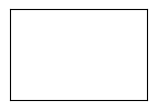

In [18]:
kernel1 = np.asarray([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
kernel2 = np.asarray([[-0.25, -0.25, -0.25], [-0.25, 3, -0.25], [-0.25, -0.25, -0.25]])
kernel3 = np.asarray([[0, -0.25, 0], [-0.25, 2, -0.25], [0, -0.25, 0]])

gray_image1_median = cv.medianBlur(gray_image1, 3)

filtered_image1 = cv.filter2D(gray_image1, -1, kernel1)
filtered_image1_median = cv.filter2D(gray_image1_median, -1, kernel1)

plt.subplot(332)
plt.xticks([]), plt.yticks([])
plt.title(f'Свертка изображения с ядром 1 \n'
          f'PSNR = {getPSNR(gray_image1, filtered_image1):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, filtered_image1):.3f}')
plt.imshow(filtered_image1, 'gray')

plt.show()

C:\Users\neo10\AppData\Local\Temp\ipykernel_6984\3202119602.py:20: RuntimeWarning: divide by zero encountered in log
  magnitude_dft_shift_masked = 20 * np.log(


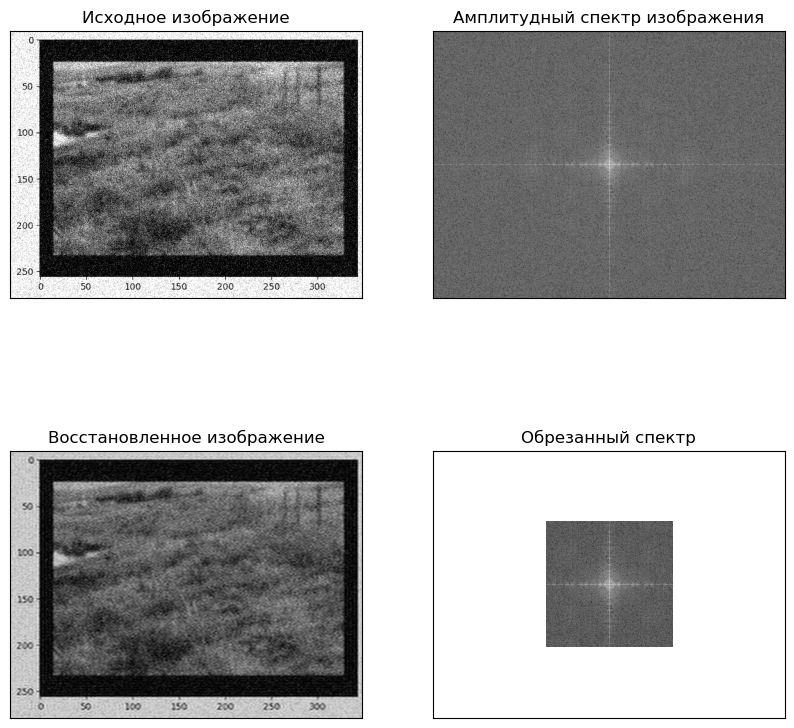

In [76]:
r = 100
rows, cols = noisy_image.shape
crow, ccol = np.uint32((rows / 2, cols / 2))
# create a mask first, center square is 1, remaining all zeros
mask = np.zeros((rows, cols, 1), np.uint8)
mask[crow - r:crow + r, ccol - r:ccol + r] = 1

# вычисляем фурье-образ
dft = cv.dft(np.float32(noisy_image), flags=cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

# применяем маску и делаем обратное преобразование Фурье
dft_shift_masked = dft_shift * mask
f_ishift = np.fft.ifftshift(dft_shift_masked)
img_back = cv.idft(f_ishift)
img_back = cv.magnitude(img_back[..., 0], img_back[..., 1])

magnitude_dft_shift = 20 * np.log(
    cv.magnitude(dft_shift[..., 0], dft_shift[..., 1]))
magnitude_dft_shift_masked = 20 * np.log(
    cv.magnitude(dft_shift_masked[..., 0], dft_shift_masked[..., 1]))

# вывод
plt.figure(figsize=(10, 10))
plt.subplot(221), plt.imshow(noisy_image, cmap='gray')
plt.title('Исходное изображение'), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(magnitude_dft_shift, cmap='gray')
plt.title('Амплитудный спектр изображения'), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(img_back, cmap='gray')
plt.title('Восстановленное изображение'), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(magnitude_dft_shift_masked, cmap='gray')
plt.title('Обрезанный спектр'), plt.xticks([]), plt.yticks([])
plt.show()

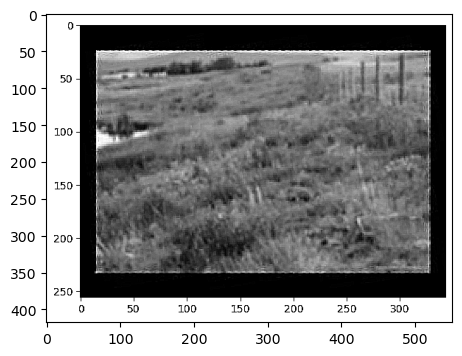

In [13]:
scale_percent = 100  # Процент от изначального размера
width = int(filtered_image1.shape[1] * scale_percent / 100)
height = int(filtered_image1.shape[0] * scale_percent / 100)
dim = (width, height)
resized_image = cv.resize(filtered_image1, dim, interpolation=cv.INTER_AREA)
plt.imshow(resized_image, 'gray')